In [20]:
# !pip install kaggle
# !kaggle datasets download -p ../dataset/ --unzip samithsachidanandan/human-face-emotions

In [41]:
import os
import numpy as np
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [22]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [23]:
classes_path = '../dataset/Data/'
class_to_images = dict()

for class_name in os.listdir(classes_path):
    class_path = os.path.join(classes_path, class_name)
    class_to_images[class_name] = np.array([os.path.join(class_path, image) for image in os.listdir(class_path)])
    print(f'{class_name} class size: {len(class_to_images[class_name])}')

Angry class size: 10148
Fear class size: 9732
Happy class size: 18439
Sad class size: 12553
Suprise class size: 8227


In [24]:
train_ratio = 0.7
train_images = dict()
val_images = dict()
test_images = dict()

for class_name in class_to_images:
    class_images = class_to_images[class_name]
    class_size = len(class_images)
    train_indexes = np.random.choice(class_size, round(class_size * train_ratio), replace=False)
    train_images[class_name] = class_images[train_indexes]
    remaining_images = np.delete(class_images, train_indexes)
    val_indexes = np.random.choice(len(remaining_images), round(len(remaining_images) * 0.5), replace=False)
    val_images[class_name] = remaining_images[val_indexes]
    test_images[class_name] = np.delete(remaining_images, val_indexes)

for class_name in class_to_images:
    print('-' * 10)
    print(f'Class: {class_name}')
    print(f'Train size: {len(train_images[class_name])}')
    print(f'Val size: {len(val_images[class_name])}')
    print(f'Test size: {len(test_images[class_name])}')

----------
Class: Angry
Train size: 7104
Val size: 1522
Test size: 1522
----------
Class: Fear
Train size: 6812
Val size: 1460
Test size: 1460
----------
Class: Happy
Train size: 12907
Val size: 2766
Test size: 2766
----------
Class: Sad
Train size: 8787
Val size: 1883
Test size: 1883
----------
Class: Suprise
Train size: 5759
Val size: 1234
Test size: 1234


In [25]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
device

device(type='cuda')

In [26]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(class_to_images.keys()))
resnet18 = resnet18.to(device)

In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

eval_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [28]:
class HumanFaceEmotionsDataset(Dataset):
    def __init__(self, images_dict, transforms=None):
        super().__init__()
        self.class_to_num = {list(images_dict.keys())[i]: i for i in range(len(list(images_dict.keys())))}
        self.classes_names = list(images_dict.keys())
        self.images = []
        self.labels = []
        self.transforms = transforms

        for class_name in images_dict:
            for image in images_dict[class_name]:
                self.images.append(image)
                self.labels.append(self.class_to_num[class_name])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_path = self.images[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image, label

    def get_class_name(self, class_number):
        return self.classes_names[class_number]

In [29]:
train_ds = HumanFaceEmotionsDataset(train_images, train_transforms)
val_ds = HumanFaceEmotionsDataset(val_images, eval_transforms)
test_ds = HumanFaceEmotionsDataset(test_images, eval_transforms)
len(train_ds), len(val_ds), len(test_ds)

(41369, 8865, 8865)

In [30]:
image_sample = train_ds[10_000][0]
label_sample = train_ds[10_000][1]
image_sample.shape, label_sample

(torch.Size([3, 224, 224]), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7162529..3.117904].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

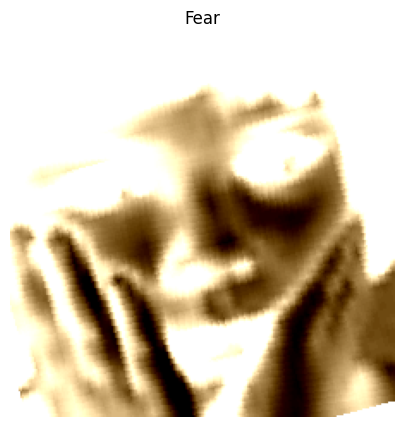

In [31]:
plt.figure(figsize=(5, 5))
plt.imshow(1 - image_sample.permute(1, 2, 0))
plt.title(train_ds.get_class_name(label_sample))
plt.axis('off')

In [32]:
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False
)

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=1e-3)

In [34]:
def train(model, loader, loss_fn, optimizer):
    preds = []
    labels = []
    losses = []

    model.train()
    pbar = tqdm(total=len(loader))
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        preds += torch.argmax(output, dim=1).cpu().detach().tolist()
        labels += y.cpu().detach().tolist()
        losses.append(loss.item())
        pbar.update(1)
    pbar.close()

    preds_tensor = torch.tensor(preds)
    labels_tensor = torch.tensor(labels)
    accuracy = (preds_tensor == labels_tensor).float().mean()
    loss = sum(losses) / len(losses)
    print(f'Accuracy: {accuracy.item()}')
    print(f'Loss: {loss}')

    return accuracy.item(), loss

In [35]:
def eval(model, loader, loss_fn):
    preds = []
    labels = []
    losses = []

    model.eval()
    with torch.no_grad():
        pbar = tqdm(total=len(loader))
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fn(output, y)
            preds += torch.argmax(output, dim=1).cpu().detach().tolist()
            labels += y.cpu().detach().tolist()
            losses.append(loss.item())
            pbar.update(1)
        pbar.close()

    preds_tensor = torch.tensor(preds)
    labels_tensor = torch.tensor(labels)
    accuracy = (preds_tensor == labels_tensor).float().mean()
    loss = sum(losses) / len(losses)
    print(f'Accuracy: {accuracy.item()}')
    print(f'Loss: {loss}')

    return accuracy.item(), loss

In [36]:
epochs = 30
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
min_val_loss = None

for epoch in range(1, epochs + 1):
    print('-' * 10)
    print(f'Epoch {epoch}:')
    train_accuracy, train_loss = train(resnet18, train_loader, loss_fn, optimizer)
    val_accuracy, val_loss = eval(resnet18, val_loader, loss_fn)
    if not min_val_loss:
        min_val_loss = val_loss
    elif epoch == epochs:
        torch.save(resnet18.state_dict(), '../models/last_model.pth')
    elif val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(resnet18.state_dict(), '../models/best_model.pth')
    scheduler.step(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

----------
Epoch 1:


100%|██████████| 1293/1293 [03:40<00:00,  5.86it/s]


Accuracy: 0.6163310408592224
Loss: 0.9543724222323365


100%|██████████| 278/278 [00:35<00:00,  7.76it/s]


Accuracy: 0.699379563331604
Loss: 0.7837890531572935
----------
Epoch 2:


100%|██████████| 1293/1293 [03:39<00:00,  5.89it/s]


Accuracy: 0.6817181706428528
Loss: 0.8054472075030495


100%|██████████| 278/278 [00:34<00:00,  8.15it/s]


Accuracy: 0.6882120966911316
Loss: 0.8045807427746786
----------
Epoch 3:


100%|██████████| 1293/1293 [03:38<00:00,  5.91it/s]


Accuracy: 0.7079697251319885
Loss: 0.7464367514281705


100%|██████████| 278/278 [00:34<00:00,  8.03it/s]


Accuracy: 0.7329949140548706
Loss: 0.6915576346620596
----------
Epoch 4:


100%|██████████| 1293/1293 [03:38<00:00,  5.91it/s]


Accuracy: 0.7296284437179565
Loss: 0.6912517651558291


100%|██████████| 278/278 [00:33<00:00,  8.35it/s]


Accuracy: 0.7469825148582458
Loss: 0.6645997226131048
----------
Epoch 5:


100%|██████████| 1293/1293 [03:39<00:00,  5.90it/s]


Accuracy: 0.748700737953186
Loss: 0.6433667116218634


100%|██████████| 278/278 [00:34<00:00,  8.17it/s]


Accuracy: 0.7469825148582458
Loss: 0.6814498814566583
----------
Epoch 6:


100%|██████████| 1293/1293 [03:38<00:00,  5.93it/s]


Accuracy: 0.7673620581626892
Loss: 0.5966349308193882


100%|██████████| 278/278 [00:34<00:00,  8.06it/s]


Accuracy: 0.7706711888313293
Loss: 0.603475674477627
----------
Epoch 7:


100%|██████████| 1293/1293 [03:37<00:00,  5.95it/s]


Accuracy: 0.7893108129501343
Loss: 0.5447301395692663


100%|██████████| 278/278 [00:33<00:00,  8.21it/s]


Accuracy: 0.7763113379478455
Loss: 0.5966928933325003
----------
Epoch 8:


100%|██████████| 1293/1293 [03:40<00:00,  5.87it/s]


Accuracy: 0.8092291355133057
Loss: 0.49580360441385823


100%|██████████| 278/278 [00:34<00:00,  8.03it/s]


Accuracy: 0.7956006526947021
Loss: 0.5555685540332908
----------
Epoch 9:


100%|██████████| 1293/1293 [03:39<00:00,  5.88it/s]


Accuracy: 0.8299692869186401
Loss: 0.4460948202514132


100%|██████████| 278/278 [00:33<00:00,  8.40it/s]


Accuracy: 0.8036097288131714
Loss: 0.5445948383074066
----------
Epoch 10:


100%|██████████| 1293/1293 [03:33<00:00,  6.06it/s]


Accuracy: 0.8479295969009399
Loss: 0.40579160597904285


100%|██████████| 278/278 [00:32<00:00,  8.68it/s]


Accuracy: 0.8163564801216125
Loss: 0.5030148843028616
----------
Epoch 11:


100%|██████████| 1293/1293 [03:31<00:00,  6.11it/s]


Accuracy: 0.8644395470619202
Loss: 0.3649379306941741


100%|██████████| 278/278 [00:33<00:00,  8.26it/s]


Accuracy: 0.8333897590637207
Loss: 0.47446418886756353
----------
Epoch 12:


100%|██████████| 1293/1293 [03:35<00:00,  6.01it/s]


Accuracy: 0.8813846111297607
Loss: 0.3219881241151462


100%|██████████| 278/278 [00:33<00:00,  8.26it/s]


Accuracy: 0.8409475684165955
Loss: 0.4663560881150431
----------
Epoch 13:


100%|██████████| 1293/1293 [03:29<00:00,  6.18it/s]


Accuracy: 0.8925765752792358
Loss: 0.29608481630325684


100%|██████████| 278/278 [00:32<00:00,  8.65it/s]


Accuracy: 0.8496333956718445
Loss: 0.46610294148768133
----------
Epoch 14:


100%|██████████| 1293/1293 [03:29<00:00,  6.16it/s]


Accuracy: 0.9059682488441467
Loss: 0.2621663774133927


100%|██████████| 278/278 [00:33<00:00,  8.22it/s]


Accuracy: 0.8571912050247192
Loss: 0.4577486476887741
----------
Epoch 15:


100%|██████████| 1293/1293 [03:35<00:00,  6.00it/s]


Accuracy: 0.913413405418396
Loss: 0.24076821973398962


100%|██████████| 278/278 [00:33<00:00,  8.39it/s]


Accuracy: 0.860349714756012
Loss: 0.4274463820230993
----------
Epoch 16:


100%|██████████| 1293/1293 [03:31<00:00,  6.10it/s]


Accuracy: 0.9197466969490051
Loss: 0.22193286359909423


100%|██████████| 278/278 [00:33<00:00,  8.37it/s]


Accuracy: 0.8750141263008118
Loss: 0.4413575327523026
----------
Epoch 17:


100%|██████████| 1293/1293 [03:31<00:00,  6.12it/s]


Accuracy: 0.9277478456497192
Loss: 0.20374389572900253


100%|██████████| 278/278 [00:31<00:00,  8.76it/s]


Accuracy: 0.8715171813964844
Loss: 0.4569422839026858
----------
Epoch 18:


100%|██████████| 1293/1293 [03:28<00:00,  6.20it/s]


Accuracy: 0.9349754452705383
Loss: 0.18543737541454897


100%|██████████| 278/278 [00:31<00:00,  8.81it/s]


Accuracy: 0.8855047821998596
Loss: 0.42167460981062566
----------
Epoch 19:


100%|██████████| 1293/1293 [03:30<00:00,  6.14it/s]


Accuracy: 0.9380212426185608
Loss: 0.17720952914049598


100%|██████████| 278/278 [00:34<00:00,  8.03it/s]


Accuracy: 0.8865200281143188
Loss: 0.4309630259938903
----------
Epoch 20:


100%|██████████| 1293/1293 [03:36<00:00,  5.98it/s]


Accuracy: 0.9422997832298279
Loss: 0.16593845013013342


100%|██████████| 278/278 [00:32<00:00,  8.52it/s]


Accuracy: 0.8857303857803345
Loss: 0.4052296576232326
----------
Epoch 21:


100%|██████████| 1293/1293 [03:39<00:00,  5.88it/s]


Accuracy: 0.9442819356918335
Loss: 0.1587347564599365


100%|██████████| 278/278 [00:33<00:00,  8.19it/s]


Accuracy: 0.8927242159843445
Loss: 0.4110545523254462
----------
Epoch 22:


100%|██████████| 1293/1293 [03:41<00:00,  5.83it/s]


Accuracy: 0.9476661086082458
Loss: 0.14598273739797818


100%|██████████| 278/278 [00:33<00:00,  8.34it/s]


Accuracy: 0.8932881951332092
Loss: 0.40596282079404644
----------
Epoch 23:


100%|██████████| 1293/1293 [03:40<00:00,  5.85it/s]


Accuracy: 0.9506393671035767
Loss: 0.14136190204330118


100%|██████████| 278/278 [00:33<00:00,  8.23it/s]


Accuracy: 0.894980251789093
Loss: 0.410127642793328
----------
Epoch 24:


100%|██████████| 1293/1293 [03:41<00:00,  5.83it/s]


Accuracy: 0.972733199596405
Loss: 0.0811939936837834


100%|██████████| 278/278 [00:33<00:00,  8.19it/s]


Accuracy: 0.9157360196113586
Loss: 0.37243068768314536
----------
Epoch 25:


100%|██████████| 1293/1293 [03:41<00:00,  5.82it/s]


Accuracy: 0.9806860089302063
Loss: 0.05823279994274133


100%|██████████| 278/278 [00:34<00:00,  8.06it/s]


Accuracy: 0.9187816977500916
Loss: 0.37533877842842683
----------
Epoch 26:


100%|██████████| 1293/1293 [03:40<00:00,  5.87it/s]


Accuracy: 0.9830549359321594
Loss: 0.051156974472058685


100%|██████████| 278/278 [00:33<00:00,  8.21it/s]


Accuracy: 0.9205865859985352
Loss: 0.3844011932500599
----------
Epoch 27:


100%|██████████| 1293/1293 [03:42<00:00,  5.81it/s]


Accuracy: 0.984747052192688
Loss: 0.044916502335209656


100%|██████████| 278/278 [00:34<00:00,  7.96it/s]


Accuracy: 0.9205865859985352
Loss: 0.3901374574293742
----------
Epoch 28:


100%|██████████| 1293/1293 [03:42<00:00,  5.80it/s]


Accuracy: 0.9871401190757751
Loss: 0.039754560229731166


100%|██████████| 278/278 [00:34<00:00,  8.17it/s]


Accuracy: 0.922278642654419
Loss: 0.39111132338004884
----------
Epoch 29:


100%|██████████| 1293/1293 [03:34<00:00,  6.03it/s]


Accuracy: 0.9875510931015015
Loss: 0.03776837490044883


100%|██████████| 278/278 [00:32<00:00,  8.55it/s]


Accuracy: 0.9221658110618591
Loss: 0.39890537630713657
----------
Epoch 30:


100%|██████████| 1293/1293 [03:35<00:00,  5.99it/s]


Accuracy: 0.9880103468894958
Loss: 0.036609661021166855


100%|██████████| 278/278 [00:34<00:00,  8.15it/s]

Accuracy: 0.9213762283325195
Loss: 0.3963475364253361


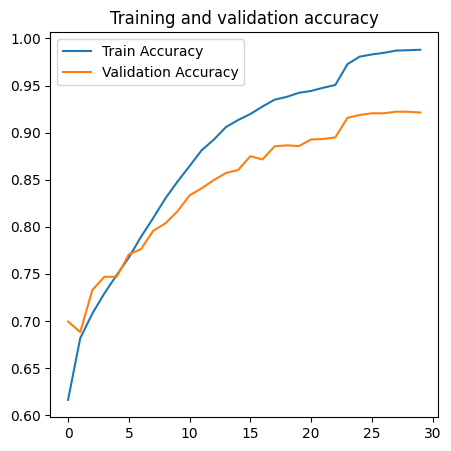

In [37]:
plt.figure(figsize=(5, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

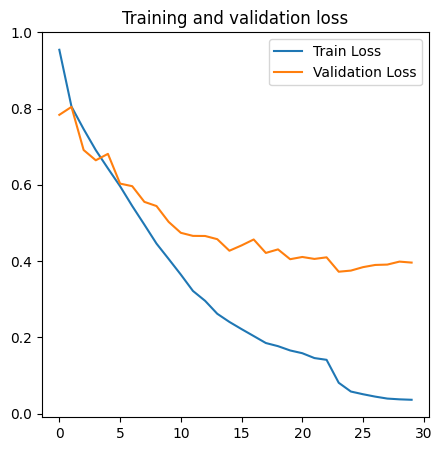

In [38]:
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

In [40]:
preds = []
labels = []

resnet18.eval()
for X, y in tqdm(test_loader):
    X, y = X.to(device), y.to(device)
    output = resnet18(X)
    labels += y.cpu().detach().tolist()
    preds += torch.argmax(output, dim=1).cpu().detach().tolist()

len(preds), len(labels)

100%|██████████| 278/278 [00:39<00:00,  7.08it/s]


(8865, 8865)

In [42]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      1522
           1       0.88      0.86      0.87      1460
           2       0.97      0.97      0.97      2766
           3       0.89      0.90      0.89      1883
           4       0.95      0.95      0.95      1234

    accuracy                           0.92      8865
   macro avg       0.92      0.92      0.92      8865
weighted avg       0.92      0.92      0.92      8865



<Axes: >

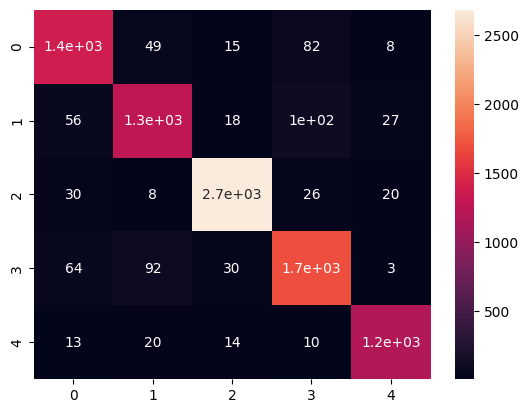

In [43]:
sns.heatmap(confusion_matrix(labels, preds), annot=True)

In [44]:
class_to_images.keys()

dict_keys(['Angry', 'Fear', 'Happy', 'Sad', 'Suprise'])